In [2]:
import pdb;
import os
import re
import time
import torch
import PIL.Image as Image

torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

In [3]:
from qwen_vl_utils import process_vision_info
from model.showui.processing_showui import ShowUIProcessor
from model.showui.modeling_showui import ShowUIForConditionalGeneration

### ShowUI Preprocessor
# 0. Common setups
min_pixels = 256*28*28
max_pixels = 1344*28*28
# 1. Screenshot -> Graph
uigraph_train = True        # Enable ui graph during training
uigraph_test = True         # Enable ui graph during inference
uigraph_diff = 1            # Pixel difference used for constructing ui graph
uigraph_rand = False        # Enable random graph construction 
# 2. Graph -> Mask 
uimask_pre = True           # Prebuild patch selection mask in the preprocessor (not in model layers) for efficiency
uimask_ratio = 0.5          # Specify the percentage of patch tokens to skip per component
uimask_rand = False         # Enable random token selection instead of uniform selection

### ShowUI Model
lm_skip_ratio = uimask_ratio # valid if not uimask_pre
lm_skip_layer = "[1,28,1]"   # [1,28,1] means we apply UI guide token selection from 1-th to 28-th layer (28 is the last layer of Qwen2-VL)

processor = ShowUIProcessor.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct", 
    min_pixels=min_pixels, max_pixels=max_pixels,
    uigraph_train=uigraph_train, uigraph_test=uigraph_test, uigraph_diff=uigraph_diff, uigraph_rand=uigraph_rand,
    uimask_pre=True, uimask_ratio=uimask_ratio, uimask_rand=uimask_rand,
)

/home/qinghong/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
lm_qwen_layer = 28

def parse_layer_type(str_ranges, L=lm_qwen_layer, default=0):
    # 0 is without layer token selection, 1 is with layer token selection. Below we provide examples:
    # [1,28,1] means that all LM layers use token selection; [1,28,0] means that do not.
    # Interleaved layer-wise '[2,2,1],[4,4,1],[6,6,1],[8,8,1],[10,10,1],[12,12,1],[14,14,1],[16,16,1],[18,18,1],[20,20,1],[22,22,1],[24,24,1],[26,26,1]'
    result = [default] * L
    matches = re.findall(r'\[\s*(\d+)\s*,\s*(\d+)\s*,\s*(\d+)\s*\]', str_ranges)
    for start, end, value in matches:
        start, end, value = int(start) - 1, int(end) - 1, int(value)
        if end >= L:
            end = L - 1
        result[start:end + 1] = [value] * (end - start + 1)
    return result

lm_skip_layer = parse_layer_type(lm_skip_layer, 28)
# print(lm_skip_layer)

model = ShowUIForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
    torch_dtype=torch.bfloat16,
    device_map="cuda:0",
    lm_skip_ratio=lm_skip_ratio, lm_skip_layer=lm_skip_layer,
)

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.33s/it]


(a) Screenshot patch number: 1323


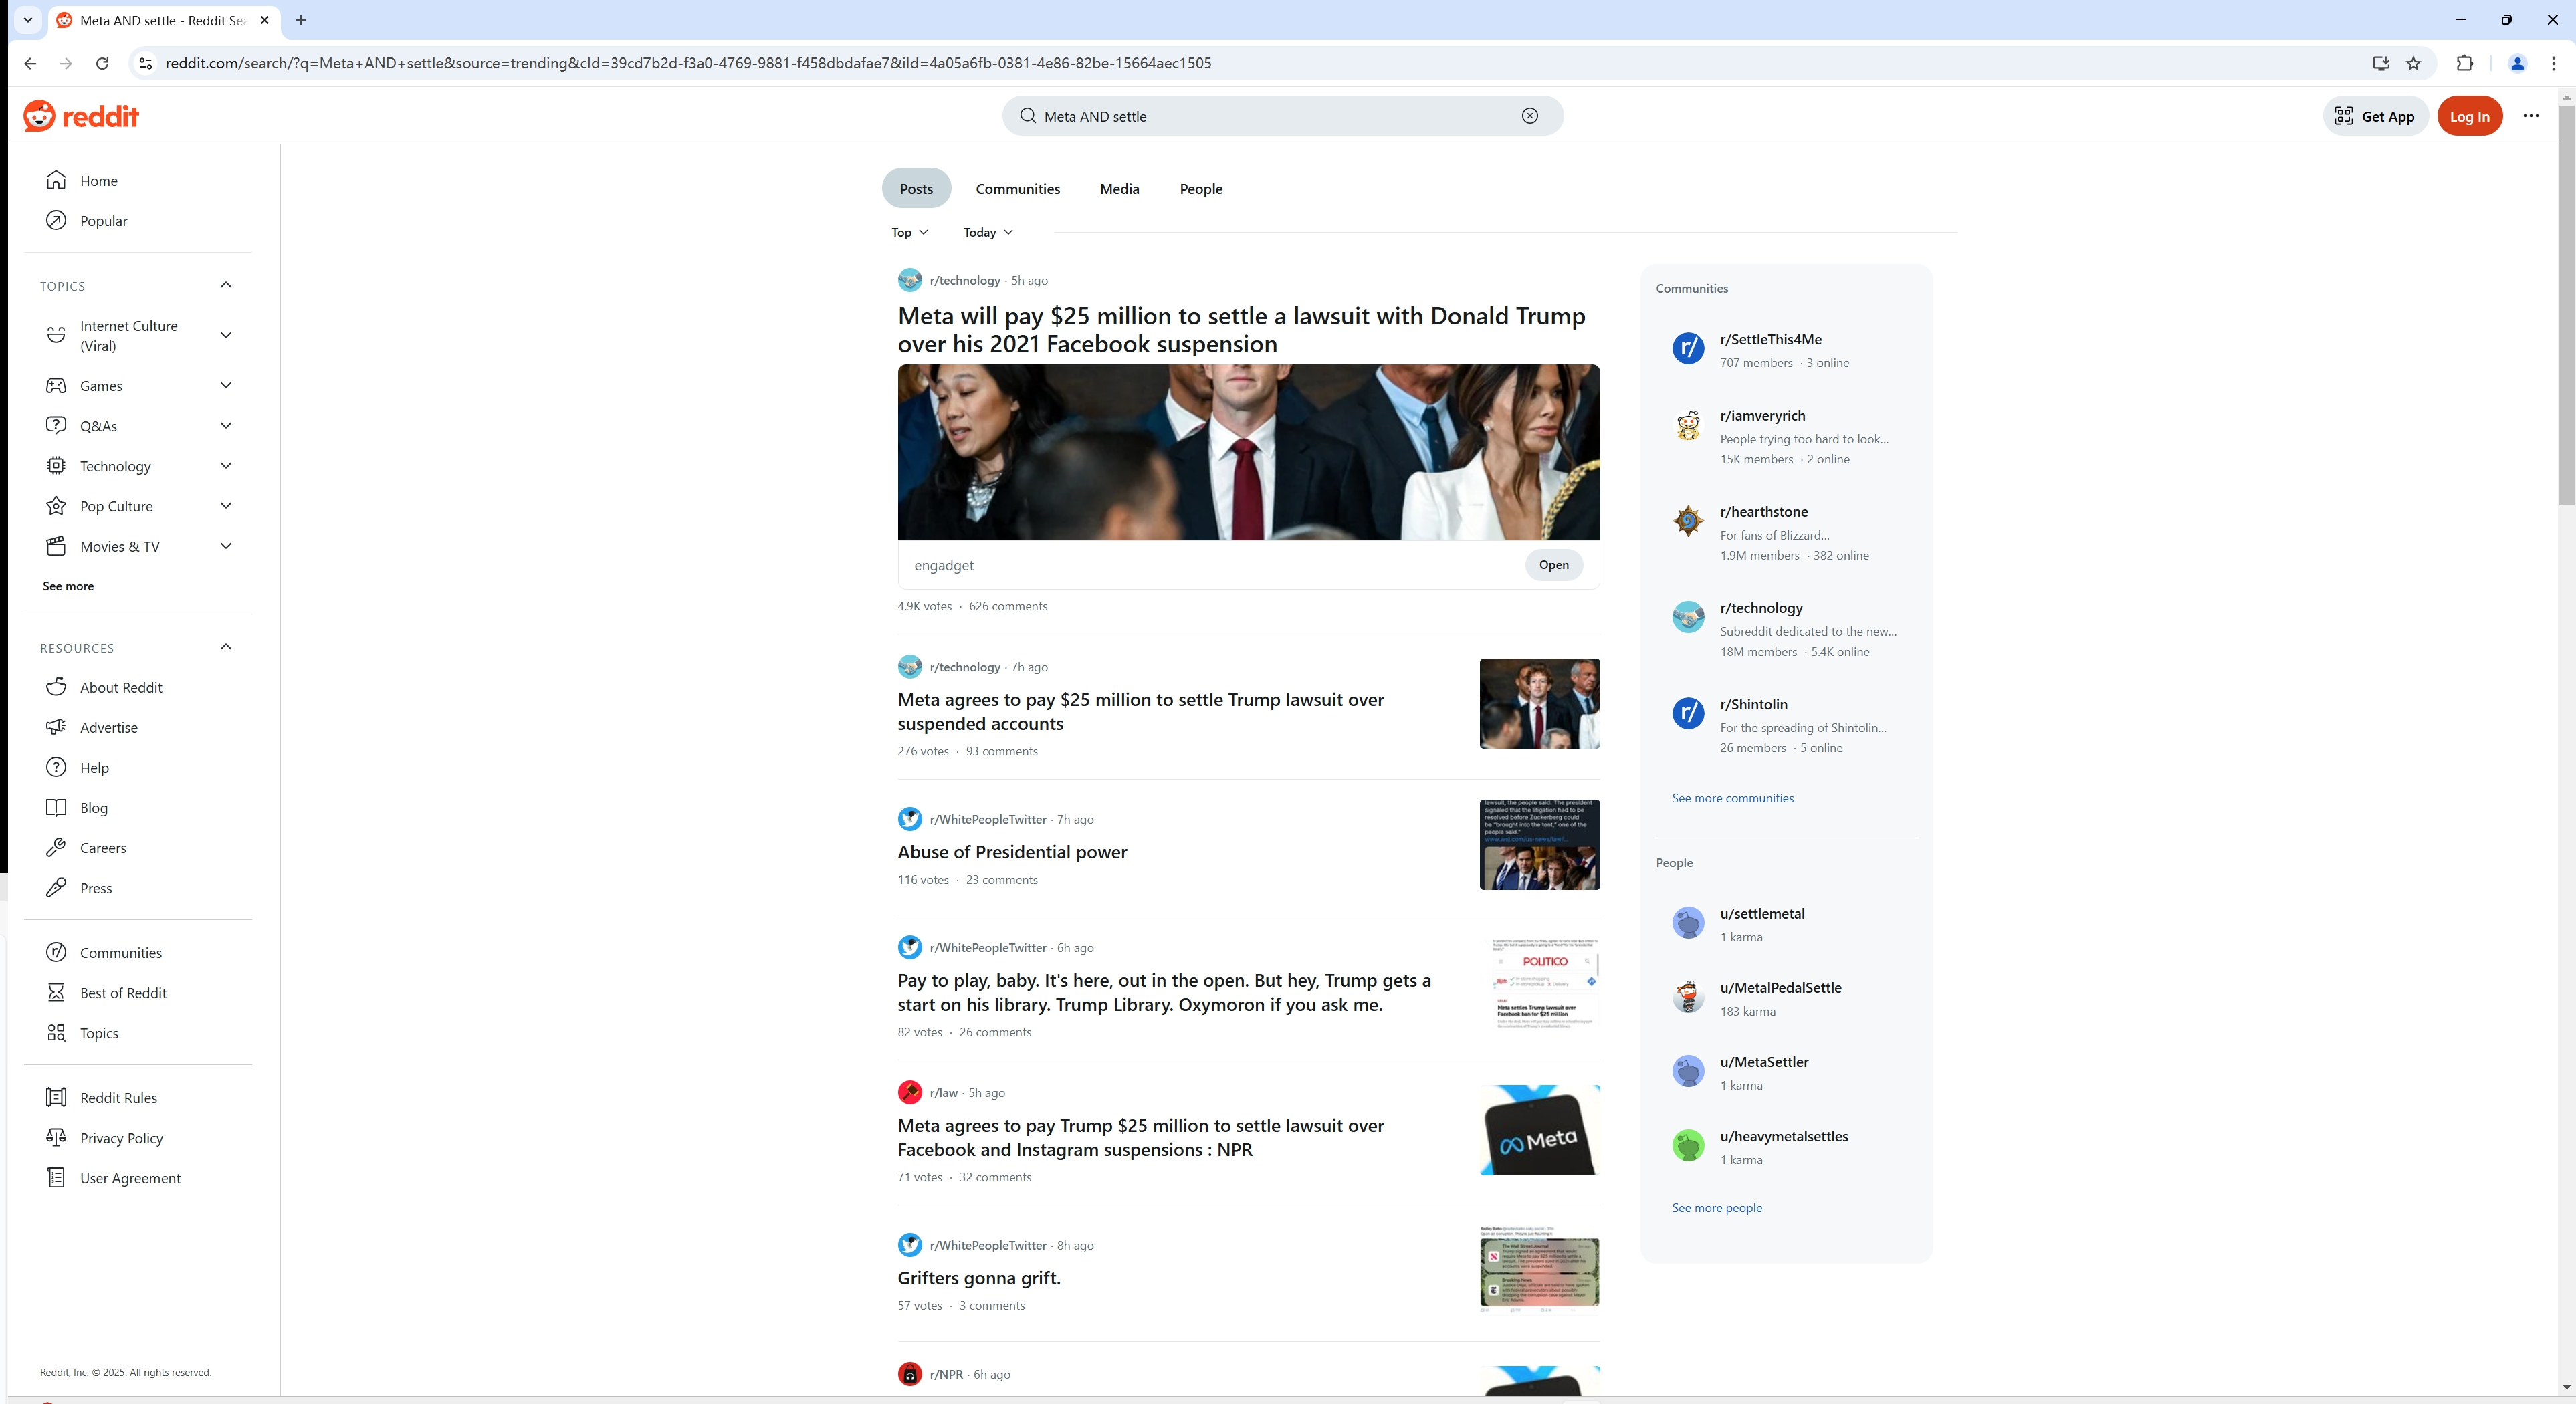

(b) By applying UI-graph, UI Component number: 500


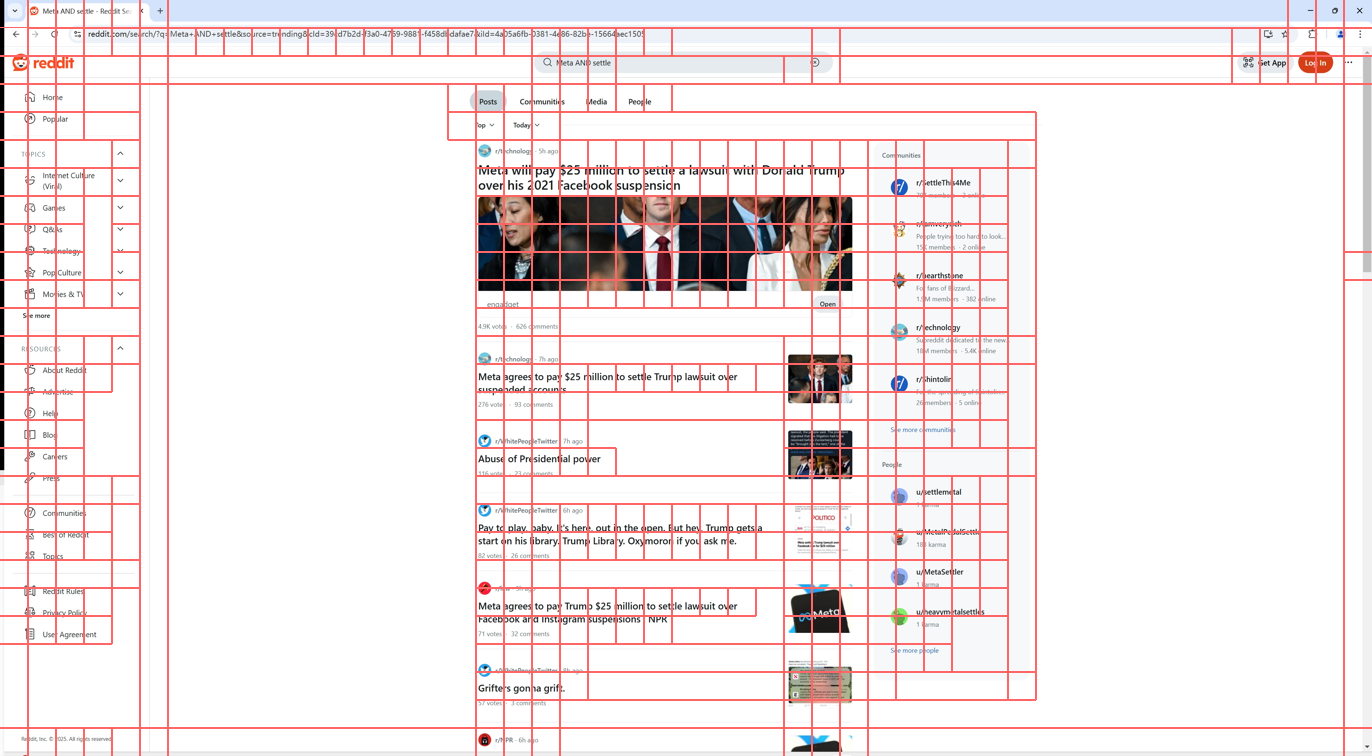

(c) Model output with skip ratio: 0.5
The image is a screenshot of a Reddit page displaying a discussion thread related to the Meta and AND settlement. The thread is titled "Meta AND settle" and is part of the subreddit r/technology. The post is from 6 hours ago and has 70K votes. The post discusses Meta's agreement to pay $25 million to settle a lawsuit with Donald Trump over his 2021 Facebook suspension.

The post includes a picture of Donald Trump and a group of people, likely representing the lawsuit. The post also mentions that Meta will pay $25 million to settle the lawsuit over Facebook and Instagram suspensions.

The subreddit community is visible on the right side of the screen, with various communities listed, including r/technology, r/AMerican, r/People, r/AMerican, r/AMerican, r/AMerican, r/AMerican, r/AMerican, r/AMerican, r/AMerican, r/AMerican, r/AMerican, r/AMerican, r/AMerican, r/AMerican, r/AMerican, r/AMerican, r/AMerican, r/AMerican, r/AMerican, r/AMerican, r/AMeric

In [8]:
# img_url = 'examples/chrome.png'
img_url = '/home/qinghong/example/Weixin Screenshot_20250130140819.png'
vis_dir = 'examples'

messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Please describe this image."},
            {
                "type": "image",
                "image": img_url,
                "min_pixels": min_pixels,
                "max_pixels": max_pixels,
            },
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True,
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
    vis_dir=vis_dir, # if provided, will be used to save the visualized img
)

inputs = inputs.to("cuda:0")

# generated_ids = model.generate(**inputs, max_new_tokens=4096, do_sample=True)
# generated_ids_trimmed = [
#     out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
# ]
# output_text = processor.batch_decode(
#     generated_ids_trimmed, 
# )[0]

print(f"(a) Screenshot patch number: {inputs['patch_assign'].shape[0]}")
display(Image.open(img_url))

print(f"(b) By applying UI-graph, UI Component number: {inputs['patch_assign_len'][0]}")
display(Image.open(f'{vis_dir}/demo.png'))

print(f"(c) Model output with skip ratio: {lm_skip_ratio}")
print(output_text)